In [14]:
##找gnen 的名称和位置会用到的
%store -r bird_01_159_gene
%store -r union_01_949
%store -r insert_035_88



##生成的三个数据集
%store -r  bird_selected_genes
%store -r union_selected_genes
%store -r inserect_selected_genes
##resampling之后的数据 分为X， Y
%store -r X_resampled_adasyn_bird
%store -r y_resampled_adasyn_bird
%store -r X_resampled_adasyn_union
%store -r y_resampled_adasyn_union
%store -r X_resampled_adasyn_inserect
%store -r y_resampled_adasyn_inserect
##分为training set 和test set 
%store -r X_train_bird
%store -r X_test_bird
%store -r y_train_bird
%store -r y_test_bird

%store -r X_train_union
%store -r X_test_union
%store -r y_train_union
%store -r y_test_union

%store -r X_train_inserect
%store -r X_test_inserect
%store -r y_train_inserect
%store -r y_test_inserect



In [113]:
import logging
import math
import numpy as np
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt
from scipy.stats import rankdata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import rankdata
from collections import Counter
import random 
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


##给数据集的每一行的最后一列加上类型 
#117+74+40+7+6
cancer_type=np.array([[0]*117+[1]*74+[2]*40+[3]*7+[4]*6],dtype=np.int64)
cancer_type=cancer_type.reshape(-1,1)
##cancer_type is a column array 

In [107]:
print(X_resampled_adasyn_union.shape)

(584, 949)


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:06:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
949


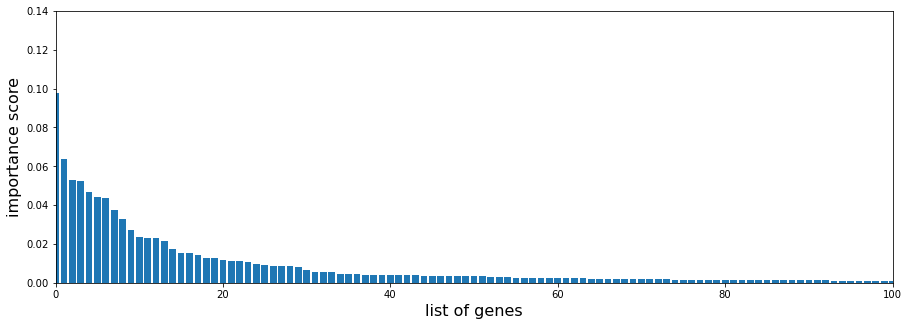

In [125]:
##therefore, I decide to apply bird_data and union data on XGBOOST and RF algo. 
##to select gene and see how accaury after selected genes 
xgbmodel = XGBClassifier(use_label_encoder=True)

##union data on XGBOOST
##用train set to select gene apply on the test part no cross validation here 
xgbmodel.fit(X_resampled_adasyn_union, y_resampled_adasyn_union)
importance_xgbmodel= xgbmodel.feature_importances_
values=list(importance_xgbmodel)
id_symbol_name_union =list(union_01_949)
xgb_birdgene_import = dict(zip(union_01_949, values))
xgb_birdgene_import_important=sorted(xgb_birdgene_import.items(),key = lambda x:x[1],reverse = True)
xgb_birdgene_import_important_adasyn = dict((x, y) for x, y in xgb_birdgene_import_important)
importance_sorted_xgbmodel=sorted(importance_xgbmodel,reverse=True)
print(len(importance_sorted_xgbmodel))
plt.figure(figsize=(15,5))
a= np.arange(0,949,1)
plt.bar(a, importance_sorted_xgbmodel)
plt.ylabel('importance score', fontsize=16)
plt.xlabel('list of genes', fontsize=16)
plt.axis([0, 100, 0, 0.14])
plt.savefig('XGBOOST_union_before.jpg')



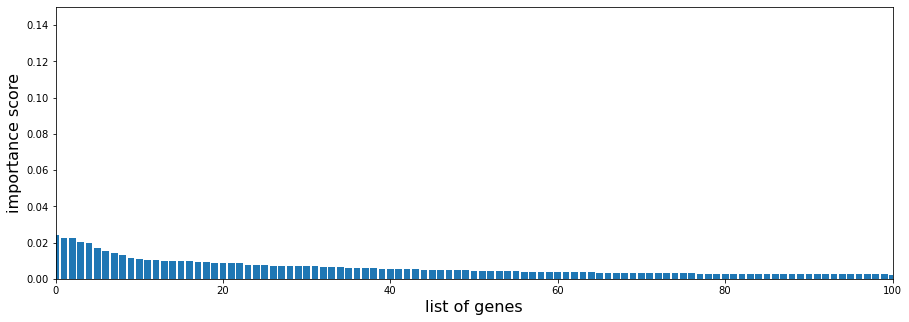

In [164]:
##bird data on random forest
rfmodel = ensemble.RandomForestClassifier( oob_score = True,n_jobs = -1,random_state =0)
rfmodel.fit(X_resampled_adasyn_union, y_resampled_adasyn_union)
importance_rfmodel= rfmodel.feature_importances_
values=list(importance_rfmodel)
id_symbol_name_bird =list(union_01_949)
rf_birdgene_import = dict(zip(union_01_949, values))
rf_birdgene_import_important=sorted(rf_birdgene_import.items(),key = lambda x:x[1],reverse = True)
rf_birdgene_import_important_adasyn = dict((x, y) for x, y in rf_birdgene_import_important)
importance_sorted_rfmodel=sorted(importance_rfmodel,reverse=True)
plt.figure(figsize=(15,5))
a= np.arange(0,949,1)

plt.bar(a, importance_sorted_rfmodel)
plt.ylabel('importance score', fontsize=16)
plt.xlabel('list of genes', fontsize=16)
plt.axis([0, 100, 0, 0.15])
plt.savefig('RF_union_before.jpg')

In [165]:
###删genes 的过程 
#从important score数值大的开始取 看取到多少 到的一个差不多的accuracy 
#################
##bird on xgbmodel
xgbmodel= XGBClassifier(use_label_encoder=True)
xgbmodel.fit(X_resampled_adasyn_union,y_resampled_adasyn_union)
#y_pred = xgbmodel.predict(X_test_bird)
# evaluate predictions
#accuracy = accuracy_score(y_test_bird, y_pred)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sorted(xgbmodel.feature_importances_,reverse = True )
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgbmodel, threshold=thresh, prefit=True)
    select_X = selection.transform(X_resampled_adasyn_union)
    print(select_X.shape)
    skf = StratifiedKFold(n_splits=10)
    skf.get_n_splits(select_X, y_resampled_adasyn_union)
    accuracy=[]

    for train_index, test_index in skf.split(select_X, y_resampled_adasyn_union):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = select_X[train_index], select_X[test_index]
        y_train, y_test = y_resampled_adasyn_union[train_index], y_resampled_adasyn_union[test_index]
        # train model
        print(X_train.shape)
        selection_model = XGBClassifier(use_label_encoder=True)
        selection_model.fit(X_train, y_train)
        # eval model
        y_pred = selection_model.predict(X_test)
        print(y_pred)
        #predictions = [round(value) for value in y_pred]
        accuracy.append( accuracy_score(y_test, y_pred))
        accu_all_fold=np.mean(accuracy)
        
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X.shape[1],accu_all_fold *100.0))
    
###.022, n=14, Accuracy: 96.24% union rf






/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:09:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(584, 1)
(525, 1)
[16:09:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0 0 4 2 0 0 0 0 2 0 3 0 1 4 1 4 4 1 0 2 0 1 4 1 1 3 3 0 2 1 4 3 4 0 2 1 1
 4 2 0 2 3 1 3 2 1 4 4 4 4 2 2 2 3 4 4 3 1 4]
(525, 1)
[16:09:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2 2 0 3 1 2 0 1 0 0 0 0 1 0 2 0 1 2 2 1 1 4 2 1 2 0 2 0 3 1 2 2 4 3 2 1 0
 2 1 1 2 3 1 3 1 2 3 4 4 3 4 4 3 0 3 1 0 4 3]
(525, 1)
[16:09:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0 2 0 0 0 4 1 0 2 0 0 2 1 2 4 3 1 1 1 2 1 2 1 3 3 3 1 0 2 1 0 2 3 3 0 3 2
 0 0 3 4 2 4 3 1 4 3 4 2 2 1 1 4 2 4 2 4 2 4]
(525, 1)
[16:09:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[3 0 0 0 1 1 1 2 0 1 0 4 1 1 1 0 4 0 2 1 1 1 1 1 2 0 2 1 2 2 0 0 1 3 2 3 1
 4 0 3 1 4 0 1 3 4 4 4 4 1 3 4 4 3 3 3 3 4 2]
(526, 1)
[16:09:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0 0 0 2 1 4 0 2 3 0 0 4 1 0 4 3 1 3 0 2 4 1 4 4 3 3 3 2 0 2 4 0 4 4 2 3 1
 3 2 0 3 3 0 0 0 1 0 4 3 3 4 4 2 3 4 4 4 3]
(526, 1)
[16:09:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


KeyboardInterrupt: 

In [156]:
##################
##bird on random forest 


rfmodel= ensemble.RandomForestClassifier(oob_score = True,n_jobs = -1,random_state =0)

rfmodel.fit(X_resampled_adasyn_union,y_resampled_adasyn_union)
#y_pred = xgbmodel.predict(X_test_bird)
# evaluate predictions
#accuracy = accuracy_score(y_test_bird, y_pred)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sorted(rfmodel.feature_importances_,reverse = True )
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(rfmodel, threshold=thresh, prefit=True)
    select_X = selection.transform(X_resampled_adasyn_union)
    print(select_X.shape)
    skf = StratifiedKFold(n_splits=10)
    skf.get_n_splits(select_X, y_resampled_adasyn_union)
    accuracy=[]

    for train_index, test_index in skf.split(select_X, y_resampled_adasyn_union):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = select_X[train_index], select_X[test_index]
        y_train, y_test = y_resampled_adasyn_union[train_index], y_resampled_adasyn_union[test_index]
        # train model
        print(X_train.shape)
        selection_model = ensemble.RandomForestClassifier(oob_score = True,n_jobs = -1,random_state =0)

        selection_model.fit(X_train, y_train)
        # eval model
        y_pred = selection_model.predict(X_test)
        #predictions = [round(value) for value in y_pred]
        accuracy.append( accuracy_score(y_test, y_pred))
        accu_all_fold=np.mean(accuracy)
        
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X.shape[1],accu_all_fold *100.0))
    
###
##Thresh=0.013, n=15, Accuracy: 96.41%
##Thresh=0.012, n=16, Accuracy: 97.09%


##加入一个cross validation 的过程



(584, 1)
(525, 1)
(525, 1)
(525, 1)
(525, 1)
(526, 1)
(526, 1)
(526, 1)
(526, 1)
(526, 1)
(526, 1)
Thresh=0.024, n=1, Accuracy: 52.08%
(584, 2)
(525, 2)
(525, 2)
(525, 2)
(525, 2)
(526, 2)
(526, 2)
(526, 2)
(526, 2)
(526, 2)
(526, 2)
Thresh=0.022, n=2, Accuracy: 62.53%
(584, 3)
(525, 3)
(525, 3)
(525, 3)
(525, 3)
(526, 3)
(526, 3)
(526, 3)
(526, 3)
(526, 3)


KeyboardInterrupt: 

In [153]:
##Bird_on_XGBOOST

##画剩下的gene的important score  there we use the whole data set 
xgbmodel = XGBClassifier(use_label_encoder=True)

name_of_selected_genes_bird_xgb=[i for i in xgb_birdgene_import_important_adasyn.keys()][:14]
print(name_of_selected_genes_bird_xgb)

index_list=[]
for i in name_of_selected_genes_bird_xgb:
    index_list.append(int(union_01_949[union_01_949.values == i].index.values.tolist()[0])
)

    
    ##找到location 

index_list   
location_list_bird_xgb=[]
for i in index_list:
    print(i)
    location_list_bird_xgb.append(union_01_949.index.get_loc(i))
print(location_list_bird_xgb)

['ANO5', 'SFTPB', 'IFITM5', 'VTN', 'IL17A', 'MTHFD1', 'SP7', 'SYT8', 'GLYAT', 'COLEC10', 'FAM180B', 'RARRES2', 'KRT4', 'EBF2']
9768
1426
5233
7533
3051
6267
5907
4927
10148
3971
9798
3837
10689
4044
[723, 645, 522, 628, 454, 51, 837, 386, 901, 890, 736, 826, 224, 922]


In [33]:
%store -r X_resampled_adasyn_union
%store -r X_resampled_adasyn_union

[14:54:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


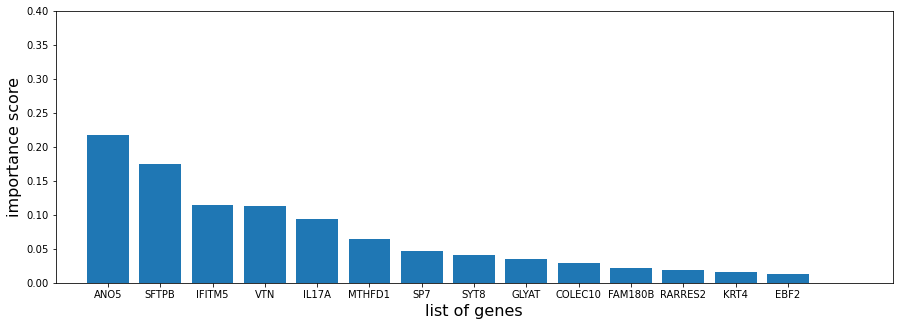

In [151]:
##用 whole data 画图 

xgbmodel.fit(X_resampled_adasyn_union[:,location_list_bird_xgb], y_resampled_adasyn_union)
importance_after_xgb = xgbmodel.feature_importances_
importance_sorted_bird_xgb=sorted(importance_after_xgb,reverse=True)


plt.figure(figsize=(15,5))
a=['ANO5', 'SFTPB', 'IFITM5', 'VTN', 'IL17A', 'MTHFD1', 'SP7', 'SYT8', 'GLYAT', 'COLEC10', 'FAM180B', 'RARRES2', 'KRT4', 'EBF2']
plt.bar(a, importance_sorted_bird_xgb[:14])
plt.ylabel('importance score', fontsize=16)
plt.xlabel('list of genes', fontsize=16)
plt.axis([-1, 15, 0, 0.4])

plt.savefig('XGBOOST_union_14gene.jpg')


In [168]:
##Bird_on_RF

##画剩下的gene的important score  there we use the whole data set 
name_of_selected_genes_bird_rf=[i for i in rf_birdgene_import_important_adasyn.keys()][:16]

index_list=[]
for i in name_of_selected_genes_bird_rf:
    index_list.append(int(union_01_949[union_01_949.values == i].index.values.tolist()[0])
)

    
    ##找到location 
print(name_of_selected_genes_bird_rf)
index_list=[]
for i in name_of_selected_genes_bird_rf:
    index_list.append(union_01_949[union_01_949.values == i].index.values.tolist()[0])
   
location_list_bird_RF=[]
for i in index_list:
    print(i)
    location_list_bird_RF.append(union_01_949.index.get_loc(i))
print(location_list_bird_RF)

['KRT4', 'SFTPB', 'GGTLC1', 'HAND2', 'IFITM5', 'TBX4', 'SP7', 'CLCA4', 'GATA4', 'APOA2', 'MMP13', 'TNNT3', 'CPN2', 'FGB', 'VTN', 'IL17A']
10689
1426
8754
2471
5233
7380
5907
427
3866
863
5475
9715
2110
2275
7533
3051
[224, 645, 270, 210, 522, 573, 837, 212, 844, 396, 623, 699, 31, 107, 628, 454]


16


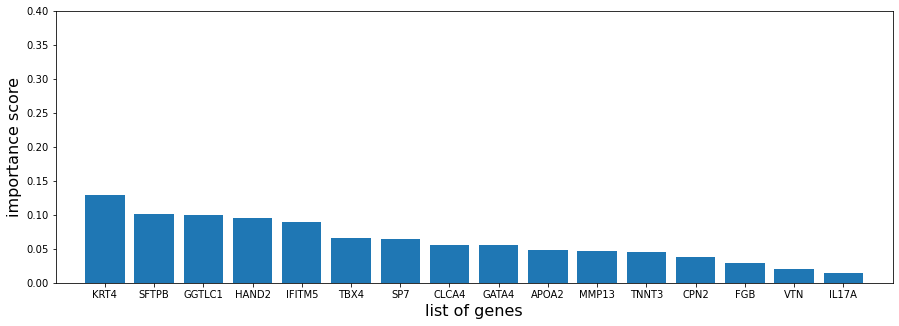

In [159]:
##用 whole data 画图 

rfmodel.fit(X_resampled_adasyn_union[:,location_list_bird_RF],y_resampled_adasyn_union)
importance_adasyn = rfmodel.feature_importances_
importance_sorted=sorted(importance_adasyn,reverse=True)


print(len(importance_sorted))
plt.figure(figsize=(15,5))
a=['KRT4', 'SFTPB', 'GGTLC1', 'HAND2', 'IFITM5', 'TBX4', 'SP7', 'CLCA4', 'GATA4', 'APOA2', 'MMP13', 'TNNT3', 'CPN2', 'FGB', 'VTN', 'IL17A']
plt.bar(a, importance_sorted[:16])
plt.ylabel('importance score', fontsize=16)
plt.xlabel('list of genes', fontsize=16)
plt.axis([-1, 16, 0, 0.4])

plt.savefig('RF_after_delect_union_16gene.jpg')


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
<ipython-input-167-8976d8e7fb2d>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfmodel.fit(X_train,y_train)
<ipython-input-167-8976d8e7fb2d>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfmodel.fit(X_train,y_train)
<ipython-input-167-8976d8e7fb2d>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfmodel.fit(X_train,y_train)
<ipython-input-167-8976d8e7fb2d>:12: DataConversionWarning: A column-vector y wa

244
Accuracy: 90.98%
[[114   2   0   1   0]
 [  9  64   0   1   0]
 [  3   0  37   0   0]
 [  4   1   0   2   0]
 [  1   0   0   0   5]]
[0.87022901 0.95522388 1.         0.5        1.        ]
[0.97435897 0.86486486 0.925      0.28571429 0.83333333]
[0.91935484 0.90780142 0.96103896 0.36363636 0.90909091]


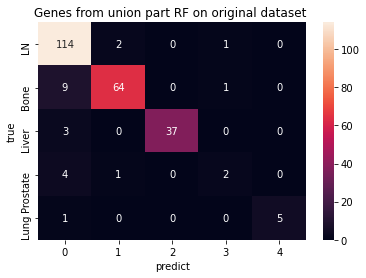

In [167]:
from sklearn.model_selection import StratifiedKFold
X = union_selected_genes[:,location_list_bird_RF]
y = cancer_type
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
y_test_list = []
pred_whole_list=[]
for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rfmodel.fit(X_train,y_train)
    y_pred = rfmodel.predict(X_test)
    # evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    for i in range (len(y_test)):
        y_test_list.append(int(y_test[i]))
        #print('y_test',y_test_list)
        ##Y-test_true  is y_test_list
   # print("pred",y_pred)
        pred_whole_list.append(y_pred.tolist()[i])
    
    
print(len(pred_whole_list))
accuracy = accuracy_score(y_test_list, pred_whole_list)
print("Accuracy: %.2f%%" % (accuracy * 100.0))    

C=confusion_matrix(y_test_list, pred_whole_list,labels=[ 0,1,2,3,4])
print(C)
f,ax=plt.subplots()

sns.heatmap(C,annot=True, fmt ='g',ax=ax,yticklabels =['LN','Bone',"Liver","Prostate","Lung"]) #画热力图

ax.set_title('Genes from union part RF on original dataset ') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.savefig('confusion matrix with the genes from union part and selected by RF_original_dataset.jpg')

print(precision_score(y_test_list, pred_whole_list, average=None)) 
print(recall_score(y_test_list, pred_whole_list, average=None))  
print(f1_score(y_test_list, pred_whole_list, average=None)) 



/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:15:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 98.29%
[2, 4, 1, 1, 0, 0, 1, 1, 1, 1, 3, 2, 0, 4, 4, 1, 4, 2, 3, 4, 0, 3, 3, 4, 4, 2, 1, 0, 0, 4, 0, 3, 0, 1, 4, 1, 3, 2, 0, 2, 4, 1, 4, 4, 4, 2, 2, 2, 1, 3, 2, 0, 2, 0, 0, 0, 3, 2, 2, 1, 1, 0, 4, 2, 3, 3, 2, 2, 3, 3, 2, 0, 2, 0, 1, 0, 4, 4, 4, 2, 0, 1, 2, 1, 1, 3, 3, 3, 1, 1, 3, 1, 4, 4, 0, 0, 1, 3, 4, 1, 4, 3, 2, 3, 4, 2, 1, 3, 3, 4, 0, 0, 2, 3, 2, 3, 0]
[2 4 1 1 0 0 1 1 1 1 3 2 0 4 4 1 4 2 3 4 0 3 3 4 4 2 1 0 0 4 0 3 0 1 4 1 3
 2 0 2 4 1 4 4 4 2 2 2 1 3 2 0 2 0 0 0 3 2 2 1 1 0 4 2 3 3 2 2 3 3 2 0 2 0
 0 0 4 4 4 2 0 1 2 1 1 3 3 3 1 1 3 1 4 4 0 0 1 3 4 0 4 3 2 3 4 2 1 3 3 4 0
 0 2 3 2 3 0]
[[23  0  0  0  0]
 [ 2 22  0  

Text(33.0, 0.5, 'true')

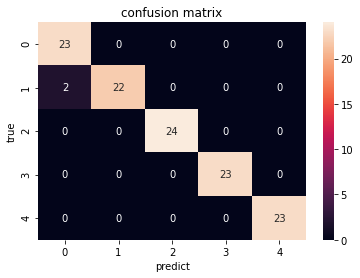

In [138]:
X_train,X_test, y_train, y_test =train_test_split(X_resampled_adasyn_union[:,location_list_bird_RF], y_resampled_adasyn_union,
                                    test_size=0.2, random_state=0,stratify=y_resampled_adasyn_union)

xgbmodel.fit(X_train,y_train)
y_pred = xgbmodel.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

##union_ RF Accuracy: Accuracy: 97.44%

y_test_list = []
for i in range (len(y_test)):
    y_test_list.append(int(y_test[i]))
print(y_test_list)
##Y-test_true  is y_test_list
print(y_pred)

C=confusion_matrix(y_test_list, y_pred,labels=[ 0,1,2,3,4])
print(C)
f,ax=plt.subplots()

sns.heatmap(C,annot=True,ax=ax) #画热力图

ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴

584
Accuracy: 97.09%
[[113   3   0   1   0]
 [  9 106   0   2   0]
 [  2   0 116   0   0]
 [  0   0   0 116   0]
 [  0   0   0   0 116]]
[0.91129032 0.97247706 1.         0.97478992 1.        ]
[0.96581197 0.90598291 0.98305085 1.         1.        ]
[0.93775934 0.9380531  0.99145299 0.98723404 1.        ]


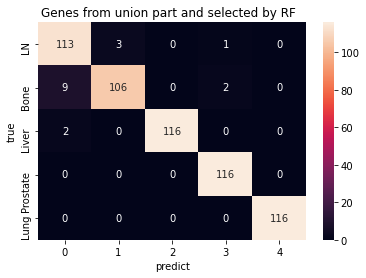

In [143]:



X = X_resampled_adasyn_union[:,location_list_bird_RF]
y = y_resampled_adasyn_union
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
y_test_list = []
pred_whole_list=[]
for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rfmodel.fit(X_train,y_train)
    y_pred = rfmodel.predict(X_test)
    # evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    for i in range (len(y_test)):
        y_test_list.append(int(y_test[i]))
        #print('y_test',y_test_list)
        ##Y-test_true  is y_test_list
   # print("pred",y_pred)
        pred_whole_list.append(y_pred.tolist()[i])
    
    
print(len(pred_whole_list))
accuracy = accuracy_score(y_test_list, pred_whole_list)
print("Accuracy: %.2f%%" % (accuracy * 100.0))    

C=confusion_matrix(y_test_list, pred_whole_list,labels=[ 0,1,2,3,4])
print(C)
f,ax=plt.subplots()

sns.heatmap(C,annot=True, fmt ='g',ax=ax,yticklabels =['LN','Bone',"Liver","Prostate","Lung"]) #画热力图

ax.set_title('Genes from union part and selected by RF  ') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.savefig(' union_RF_bal.jpg')
print(precision_score(y_test_list, pred_whole_list, average=None)) 
print(recall_score(y_test_list, pred_whole_list, average=None))  
print(f1_score(y_test_list, pred_whole_list, average=None)) 






/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 96.23%
584
[[109   6   1   1   0]
 [  6 107   0   4   0]
 [  3   0 115   0   0]
 [  1   0   0 115   0]
 [  0   0   0   0 116]]
[0.91596639 0.94690265 0.99137931 0.95833333 1.        ]
[0.93162393 0.91452991 0.97457627 0.99137931 1.        ]
[0.92372881 0.93043478 0.98290598 0.97457627 1.        ]


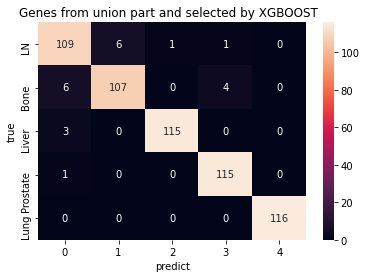

In [144]:
#### from sklearn.model_selection import StratifiedKFold
X = X_resampled_adasyn_union[:,location_list_bird_xgb]
y = y_resampled_adasyn_union
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
y_test_list = []
pred_whole_list=[]
for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    xgbmodel.fit(X_train,y_train)
    y_pred = xgbmodel.predict(X_test)
    # evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    for i in range (len(y_test)):
        y_test_list.append(int(y_test[i]))
        #print('y_test',y_test_list)
        ##Y-test_true  is y_test_list
   # print("pred",y_pred)
        pred_whole_list.append(y_pred.tolist()[i])
    
accuracy = accuracy_score(y_test_list, pred_whole_list)
print("Accuracy: %.2f%%" % (accuracy * 100.0))        
print(len(pred_whole_list))
    

C=confusion_matrix(y_test_list, pred_whole_list,labels=[ 0,1,2,3,4])
print(C)
f,ax=plt.subplots()

sns.heatmap(C,annot=True, fmt ='g',ax=ax,yticklabels =['LN','Bone',"Liver","Prostate","Lung"]) #画热力图

ax.set_title('Genes from union part and selected by XGBOOST  ') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.savefig('union_XGBOOST_bal.jpg')
print(precision_score(y_test_list, pred_whole_list, average=None)) 
print(recall_score(y_test_list, pred_whole_list, average=None))  
print(f1_score(y_test_list, pred_whole_list, average=None)) 



In [67]:
%store -r union_selected_genes
%store -r inserect_selected_genes

union_selected_genes.shape

(244, 949)

/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:22:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 89.80%
[1, 0, 0, 1, 0, 1, 0, 1, 0, 3, 2, 1, 4, 1, 1, 0, 1, 1, 1, 0, 1, 2, 0, 0, 2, 2, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0]
[1 0 0 0 0 1 0 1 0 0 2 1 4 1 1 0 1 1 1 0 1 2 1 0 2 2 0 2 0 1 1 1 1 0 0 0 2
 2 0 0 0 0 1 0 0 1 2 0 0]
[[21  3  0  0  0]
 [ 1 14  0  0  0]
 [ 0  0  8  0  0]
 [ 1  0  0  0  0]
 [ 0  0  0  0  1]]
49


Text(33.0, 0.5, 'true')

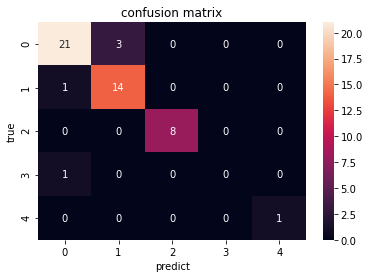

In [140]:
cancer_type=np.array([[0]*117+[1]*74+[2]*40+[3]*7+[4]*6],dtype=np.int64)
cancer_type=cancer_type.reshape(-1,1)
##UNION data confusion matrix on original data set 
##confusion matrix 在原始的数据当中呢 
X_train,X_test, y_train, y_test =train_test_split(union_selected_genes[:,location_list_bird_xgb],cancer_type,test_size=0.2, random_state=0,stratify=cancer_type)

xgbmodel.fit(X_train,y_train)
y_pred = xgbmodel.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

y_test_list = []
for i in range (len(y_test)):
    y_test_list.append(int(y_test[i]))
print(y_test_list)
##Y-test_true  is y_test_list
print(y_pred)

C=confusion_matrix(y_test_list, y_pred,labels=[0, 1, 2,3,4])
print(C)
print(len(y_test_list))
f,ax=plt.subplots()

sns.heatmap(C,annot=True,ax=ax) #画热力图

ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴

/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/chen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[00:30:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
244
Accuracy: 88.11%
[[108   7   1   1   0]
 [  8  65   0   1   0]
 [  4   0  36   0   0]
 [  5   1   0   1   0]
 [  1   0   0   0   5]]
[0.85714286 0.89041096 0.97297297 0.33333333 1.        ]
[0.92307692 0.87837838 0.9        0.14285714 0.83333333]
[0.88888889 0.88435374 0.93506494 0.2        0.90909091]


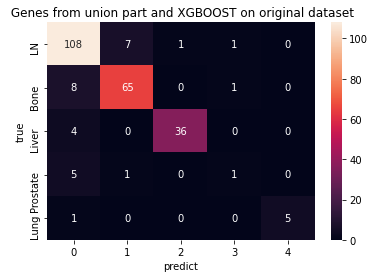

In [145]:
from sklearn.model_selection import StratifiedKFold
X = union_selected_genes[:,location_list_bird_xgb]
y = cancer_type
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
y_test_list = []
pred_whole_list=[]
for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    xgbmodel.fit(X_train,y_train)
    y_pred = xgbmodel.predict(X_test)
    # evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    for i in range (len(y_test)):
        y_test_list.append(int(y_test[i]))
        #print('y_test',y_test_list)
        ##Y-test_true  is y_test_list
   # print("pred",y_pred)
        pred_whole_list.append(y_pred.tolist()[i])
    
    
print(len(pred_whole_list))
accuracy = accuracy_score(y_test_list, pred_whole_list)
print("Accuracy: %.2f%%" % (accuracy * 100.0))    

C=confusion_matrix(y_test_list, pred_whole_list,labels=[ 0,1,2,3,4])
print(C)
f,ax=plt.subplots()

sns.heatmap(C,annot=True, fmt ='g',ax=ax,yticklabels =['LN','Bone',"Liver","Prostate","Lung"]) #画热力图

ax.set_title(' Genes from union part and XGBOOST on original dataset') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.savefig('confusion matrix with the genes from union part and selected by XGBOOST_original_dataset.jpg')

##xgb union 
print(precision_score(y_test_list, pred_whole_list, average=None)) 
print(recall_score(y_test_list, pred_whole_list, average=None))  
print(f1_score(y_test_list, pred_whole_list, average=None)) 
